In [1]:
import numpy as np
import scipy as sp
import pandas as pd

from scipy import optimize

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpt
from data_functions import generate_toy_data, get_bootstrap_data, set_intensity, get_data_to_fit
from data_functions import get_attenuation_parameters


plots needed:
- nb of events vs energy
- 

In [2]:
# input parameters for the simualtions
minE = 10**15 #eV
maxE = 10**18 #eV
gamma = -2.5 # slope of the spectrum

#relation between energy and s38
A = 10**12
B = 1.2

#attenuation true numbers
alpha = 0.919
beta = -1.13

# Minimum zenith angle in degrees
minTheta = 50

#number of events to generate
events = 10000
#number of bins for the zenith 
nr_of_bins = 8

data = generate_toy_data(events, minE, maxE, gamma, A, B, alpha, beta, minTheta)

#print(data)

(array([114., 103.,  84., 123.,  86.,  89.,  94.,  95., 103.,  97., 111.,
        102., 107.,  84., 104.,  91., 107., 109., 100., 101.,  95.,  83.,
         87.,  95., 101., 115.,  96.,  98.,  99., 107., 100.,  83.,  98.,
         94.,  86.,  78., 112.,  97.,  99., 104., 110.,  90.,  99., 109.,
        114., 109.,  98., 112., 102., 101.,  90., 103.,  98., 103., 101.,
        104., 105., 105., 102.,  96.,  89.,  95., 101., 120., 118.,  90.,
         89., 107.,  96., 108., 101., 108.,  96., 108., 109.,  84., 116.,
         80., 101.,  94.,  98.,  97.,  90.,  98., 110., 101., 111.,  95.,
        108., 100., 102., 110.,  98., 109., 101.,  95.,  97., 108.,  90.,
         90.]),
 array([0.41319397, 0.41906203, 0.42493009, 0.43079815, 0.43666621,
        0.44253427, 0.44840233, 0.45427039, 0.46013845, 0.46600651,
        0.47187457, 0.47774263, 0.48361068, 0.48947874, 0.4953468 ,
        0.50121486, 0.50708292, 0.51295098, 0.51881904, 0.5246871 ,
        0.53055516, 0.53642322, 0.54229128, 0.

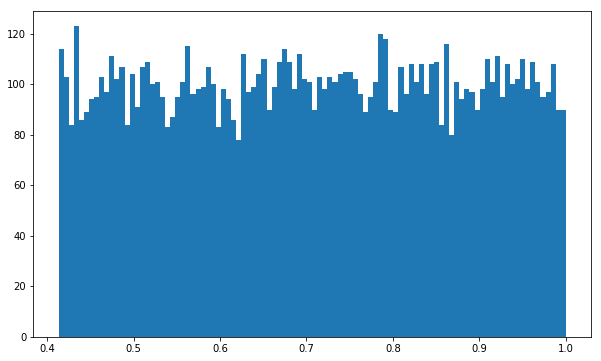

In [3]:
fig1, ax1 =plt.subplots(figsize=(10,6))

ax1.hist(data.cos2,bins=100 )


6483    1.002320e+15
806     1.000221e+15
9506    1.001466e+15
4834    1.000361e+15
4990    1.006360e+15
2580    1.003679e+15
5469    1.003201e+15
9349    1.006886e+15
6123    1.005223e+15
7999    1.006451e+15
2277    1.002384e+15
9777    1.006296e+15
9729    1.005927e+15
5062    1.004654e+15
5386    1.006702e+15
9531    1.008262e+15
6743    1.001774e+15
1924    1.002976e+15
254     1.010314e+15
1447    1.009111e+15
6210    1.001358e+15
8643    1.007615e+15
6640    1.006605e+15
6738    1.004965e+15
5628    1.002807e+15
2416    1.009289e+15
1958    1.010080e+15
5602    1.014835e+15
8432    1.003333e+15
2636    1.012489e+15
            ...     
813     4.386977e+15
612     4.371340e+15
707     4.374993e+15
7128    4.519444e+15
4488    4.500033e+15
9004    4.658309e+15
9988    4.699488e+15
1579    4.698066e+15
177     4.903008e+15
9400    4.972421e+15
812     5.004274e+15
2032    5.143888e+15
4876    5.162389e+15
8790    5.272466e+15
2711    5.491293e+15
6159    5.791846e+15
4501    5.922

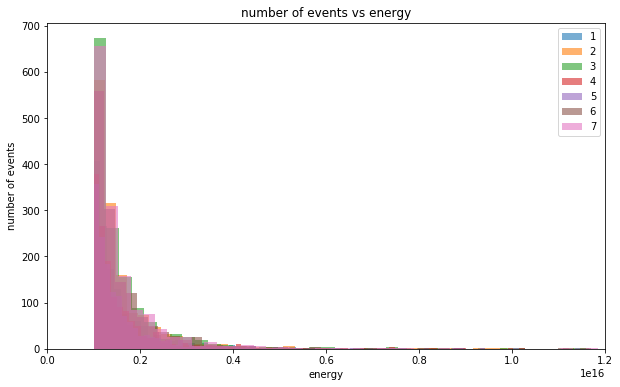

In [4]:
#### fit the attenuation curve
data,groups = set_intensity(data, nr_of_bins)      
#print(groups.size()) 
print(groups.energy.get_group(7))

fig2, ax2 =plt.subplots(figsize=(10,6))
groups.energy.plot.hist(bins=100,alpha=0.6,legend=True)
ax2.set_xlim(0,1.2*10**16)
plt.xlabel('energy')
plt.ylabel('number of events')
plt.title('number of events vs energy')
    
    
### input value the reference intensity
intensity = 100
vals, s125_fit, bins2 , s125_fit_error= get_data_to_fit(data, intensity, nr_of_bins)
#print(bins2)
values, cov = get_attenuation_parameters(s125_fit, bins2)

#print(values)

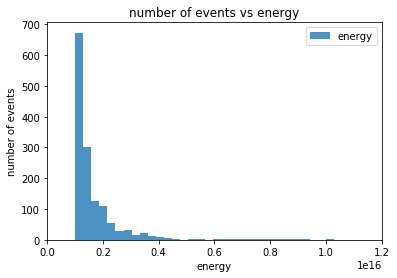

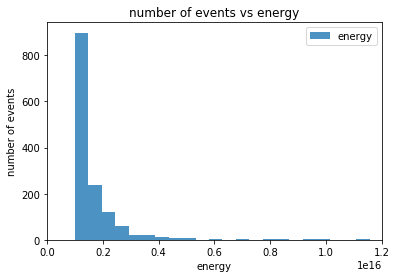

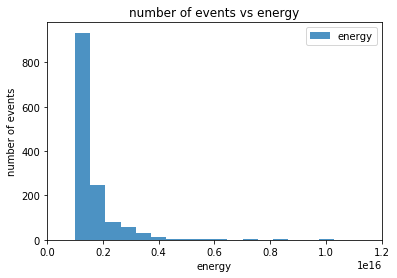

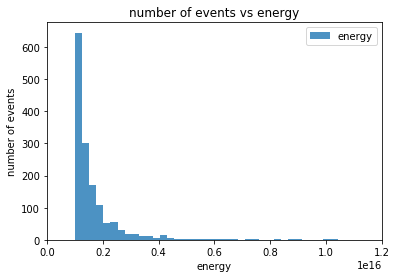

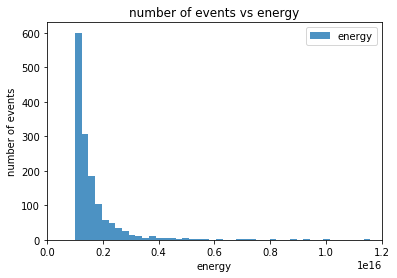

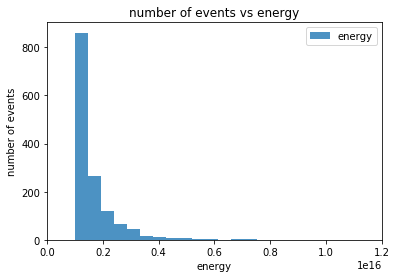

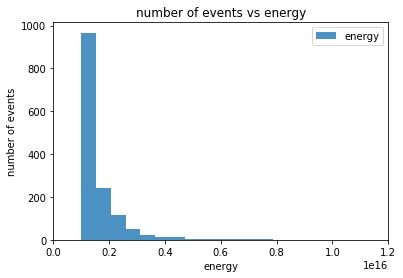

In [5]:
for name, group in groups:
    fig, axe =plt.subplots()
    group.energy.plot.hist(bins=50,alpha=0.8,legend=True)
    axe.set_xlim(0,1.2*10**16)
    plt.xlabel('energy')
    plt.ylabel('number of events')
    plt.title('number of events vs energy')

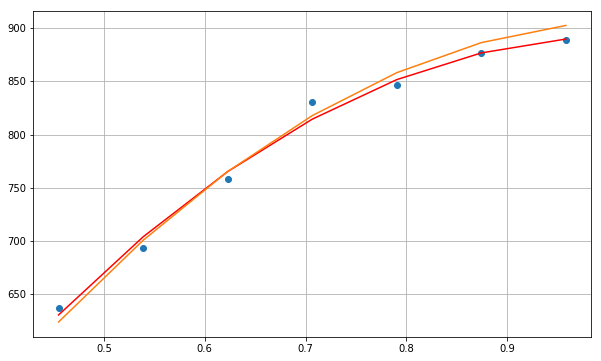

In [6]:

fig2, ax2 =plt.subplots(figsize=(10,6))
plt.grid()
from utils import get_s125 
a1=values[0]
a2=values[1]
a3=values[2]
y=get_s125(bins2, a1,a2,a3)
y2=get_s125(bins2, alpha, beta, a3)

ax2.plot(bins2, s125_fit, lw=0, marker='o')
ax2.plot(bins2,y, color="r")
ax2.plot(bins2,y2)

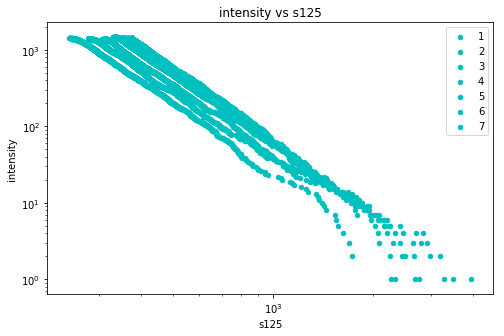

In [7]:
#groups = dict(list(data))
#print(groups)
fig, ax =plt.subplots(figsize=(8,5))
for label, group in groups:
    group.plot(x='s125',y='I',logx=True,logy=True,legend=True, c='c',ax=ax,label=label, kind='scatter')
plt.xlabel('s125')
plt.ylabel('intensity')
plt.title('intensity vs s125')
plt.legend()


(2, 4)

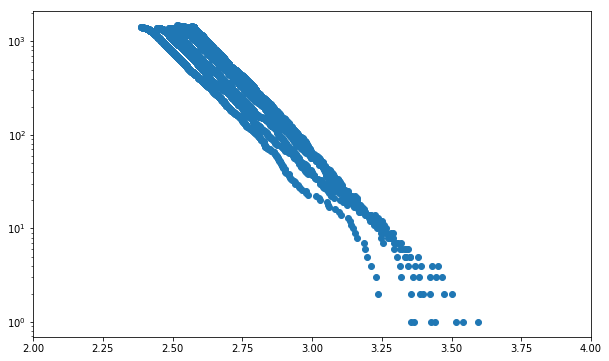

In [8]:
fig1, ax1 =plt.subplots(figsize=(10,6))
ax1.plot(np.log10(data.s125),data.I, lw=0, marker='o' )
ax1.set_yscale('log')
ax1.set_xlim(2,4)

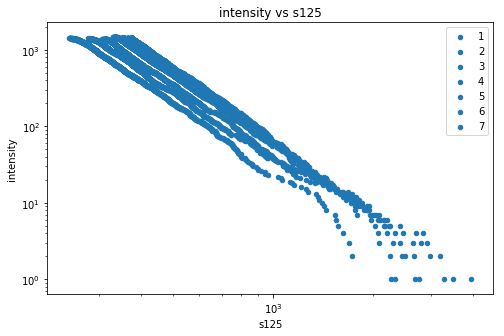

In [9]:
fig, ax =plt.subplots(figsize=(8,5))
for label, group in groups:
    group.plot(x='s125',y='I',logx=True,logy=True,legend=True, ax=ax,label=label, kind='scatter')
plt.xlabel('s125')
plt.ylabel('intensity')
plt.title('intensity vs s125')
plt.legend()

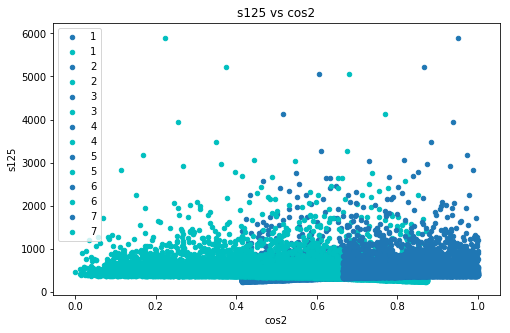

In [10]:
#s125 in fct of cos2 and zenith
fig, ax =plt.subplots(figsize=(8,5))
for label, group in groups:
    group.plot(x='cos2',y='s125',legend=True, ax=ax,label=label, kind='scatter')
    group.plot(x='zenith', y='s125', legend=True, c='c',ax=ax,label=label, kind='scatter')
plt.xlabel('cos2')
plt.ylabel('s125')
plt.title('s125 vs cos2')
plt.legend()


(            energy      cos2          s38    zenith  zenith_er         s125  \
3259  1.009983e+15  0.423113   318.856261  0.862592   0.025576   181.689255   
920   1.028238e+15  0.460755   323.651797  0.824683   0.019315   200.561411   
1695  1.018949e+15  0.455285   321.213375  0.830173   0.014665   207.542044   
1261  1.052900e+15  0.416037   330.107949  0.869761   0.025744   211.498953   
4055  1.044928e+15  0.448467   328.023793  0.837023   0.009759   213.511559   
8269  1.020676e+15  0.414102   321.667117  0.871725   0.013639   214.209160   
7505  1.050016e+15  0.433457   329.354349  0.852139   0.013220   215.975340   
5843  1.000335e+15  0.430196   316.315964  0.855431   0.019276   219.744927   
7046  1.056289e+15  0.423032   330.993173  0.862674   0.021316   220.345653   
9421  1.009092e+15  0.482921   318.621953  0.802481   0.013614   220.438015   
343   1.109560e+15  0.455114   344.846457  0.830345   0.024676   221.175817   
9876  1.065697e+15  0.437166   333.447995  0.848399

AttributeError: 'tuple' object has no attribute 'cos2'

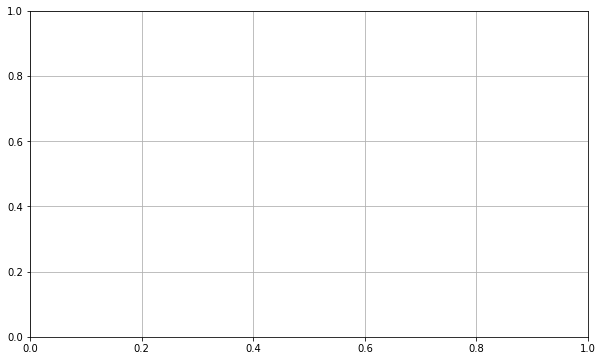

In [19]:
### number of boostrap samples as input

intensity2=[100,200,300]
samples = 2
from data_functions import get_s125

fig2, ax2 = plt.subplots(figsize=(10,6))
plt.grid()
a=[alpha,beta,1]
bootstrap_values=[]
bootstrap_values_2=[]
fitted_data=pd.DataFrame([])
#fitted_data['bs125']=[]
for j in range(0, samples):
    new_data = get_bootstrap_data(data)
    new_data=set_intensity(new_data, nr_of_bins)
    print(new_data)
    for i in range(len(intensity2)):
        val, s125_fit, bins, s125_fit_error = get_data_to_fit(new_data, intensity2[i], nr_of_bins)
        val["sample"]=j
        val["bins"]=np.digitize(bins, bins) 
        fitted_data=fitted_data.append(val)
        vals, cov_bt = get_attenuation_parameters(s125_fit, bins)
        bootstrap_values.append(vals)
        bootstrap_values_2.append(vals**2)
        ax2.plot(bins, s125_fit, lw=0, marker='o')
        ax2.plot(bins, get_s125(bins, vals[0], vals[1], vals[2]))
    print(vals)

In [16]:
I0=fitted_data.loc[fitted_data.I==100]
nb_bins=I0.bins.max()-I0.bins.min()+1
for i,j in enumerate(intensity2):
    I0=fitted_data.loc[fitted_data.I==j]
    nb_bins=I0.bins.max()-I0.bins.min()+1
    for k in range(1,nb_bins):
        df=fitted_data.loc[fitted_data.bins==1]
        df = df.loc[df.I == j]
    print(df)
    print(df.s125.var())



4951    0.414136
9737    0.416769
1146    0.420523
8269    0.414102
6860    0.414970
4664    0.422942
1049    0.419006
2942    0.422804
3259    0.423113
4414    0.426219
5843    0.430196
6584    0.420538
1036    0.420089
2264    0.419588
9747    0.423285
337     0.428088
3211    0.415133
6237    0.431190
4576    0.431032
489     0.431999
9968    0.426824
5456    0.425225
6678    0.434497
2518    0.431483
5615    0.428482
2253    0.436181
1261    0.416037
5563    0.424708
380     0.426947
7038    0.415635
          ...   
8130    0.677444
2755    0.434322
4494    0.810614
3588    0.696535
7645    0.531708
9385    0.632416
6090    0.509102
1205    0.802460
8560    0.648111
9504    0.556203
92      0.466329
8231    0.621551
1573    0.632393
3436    0.778862
7230    0.838908
3937    0.549081
6211    0.849948
7456    0.987049
473     0.929521
9719    0.874401
6728    0.729513
8118    0.815975
8864    0.971908
7150    0.610257
4001    0.882291
6482    0.936711
2619    0.516942
8982    0.6041

AttributeError: 'DataFrame' object has no attribute 'I'

In [ ]:
### number of boostrap samples as input
samples = 2
from data_funcs import get_s125

fig2, ax2 = plt.subplots(figsize=(10,6))
plt.grid()
a=[alpha,beta,1]
bootstrap_values=[]
bootstrap_values_2=[]
for j in range(0, samples):
    new_data = get_bootstrap_data(data)
    new_data=set_intensity(new_data, nr_of_bins)
    s125_fit, bins, s38_fit, s125_fit_error = get_data_to_fit(new_data, intensity, nr_of_bins)
    vals, cov_bt = get_attenuation_parameters(s125_fit, bins)
    bootstrap_values.append(vals)
    bootstrap_values_2.append(vals**2)
    ax2.plot(bins, s125_fit, lw=0, marker='o')
    ax2.plot(bins, get_s125(bins, vals[0], vals[1], vals[2]))
    print(vals)


Things to do:
1. From the bootstrap get all the values and plot them in an histogram and one vs each other (in one canvas)
2. Give final results: values(from original data) +- rms(vals)
3. Implement MCMC fit in the get_attenuation_parameters function
4. Compare results with 2.
5. See/write to Ioana/Zig

In [ ]:
from data_funcs import get_attenuation_parameters2

params_scipy, cov2 = sp.optimize.curve_fit(get_s125, bins, s125_fit)
# Use as guess
a_true = params_scipy[0]
b_true = params_scipy[1]
f_true = params_scipy[2]

#final_parameters, cov2, sample = get_attenuation_parameters2(s125_fit, s38_fit, s125_fit_error, bins, performMCMC=True)
sample = get_attenuation_parameters2(params_scipy, s125_fit, s125_fit_error, bins)

In [ ]:
import math
cos_ref = np.cos(math.radians(38))**2
cos2 = bins - cos_ref
# Plot a subset of the samples
for a, b, f in sample[np.random.randint(len(sample), size=100)]:
    plt.plot(cos2, f * (b * cos2**2 + a * cos2 + 1), color="k", alpha=0.1)
    plt.plot(cos2, f_true * (b_true * cos2**2 + a_true * cos2 + 1), color="r", lw=2, alpha=0.8)
    plt.errorbar(cos2, y, yerr=s125_fit_error, fmt=".k")

In [ ]:
import corner
fig = corner.corner(sample, labels=["$a$","$b$", "$s38$"], truths=[alpha,beta, a3])
fig.savefig("")

In [ ]:
a_mcmc,  b_mcmc,  s38_mcmc  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(sample, [16, 50, 84],
                                                axis=0)))

#(mid_value, +error, -error)
print("a = %f + %f - %f\n"%(a_mcmc[0],a_mcmc[1],a_mcmc[2]))
print("b = %f + %f - %f\n"%(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
print("s38 = %f + %f - %f\n"%(s38_mcmc[0],s38_mcmc[1],s38_mcmc[2]))